In [4]:
import pandas as pd 
import requests, json, os, tempfile

class ACGUIKIT_REQUESTS:
  def __init__(self, url): 
    self.JOBID = ""; 
    self.url = url; 
    
  def initiate(self, jobid): 
    assert len(jobid) ==8, "Please provide a valid 8-character session ID ";
    self.JOBID = jobid
    emptypdb = "ATOM      1  CH3 LIG A   1      -8.965  24.127  -8.599  1.00  0.00\nEND"
    self.submitPDB(emptypdb, mode="str"); 
  
  def recall(self, jobid):
    """
      Primarily to obtain the session ligand and protein structure
    """
    assert len(jobid) == 8, "Please provide a valid 8-character session ID ";
    data = { 'cmd': 'recallSession', 'JOBID': jobid}; 
    response = requests.post(self.url, data=data); 
    if response.status_code==200:
      ret = json.loads(response.text); 
      self.protein = ret["pdbfile"]; 
      self.ligand = ret["molfile"]; 
      self.JOBID = jobid; 
      return ret
    else:
      print("Recall session failed"); 
      return;
    
  def listTraj(self): 
    assert len(self.JOBID) == 8, "Please provide a valid 8-character session ID "; 
    data = {'cmd': 'sendtraj','JOBID': self.JOBID,'querymode': '7'}; 
    response = requests.post(self.url, data=data); 
    if response.status_code==200:
      ret = json.loads(response.text)
      for key, val in json.loads(ret["Params"]).items(): 
        atomnr = val["atomnr"] or 0; 
        waternr = val["watnr"] or 0; 
        date = val["gendate"]; 
        eng = val["prodeng"]; 
        interval = val["outinterval"] or 0; 
        nsteps = val["nrsteps"] or 0; 
        ensemble = val["ensemble"]; 
        status = val["exitmsg"]
        print(f"{key}: {ensemble:3s}|{int(atomnr):6d}|{int(waternr):6d}|{int(interval):6d}|{int(nsteps):8d}|{eng:6s}|{date:18s}|{status}")
      return ret
    else:
      print("List trajectory failed"); 
      return
    
  def recallTraj(self, trajid): 
    assert len(self.JOBID) == 8, "Please provide a valid 8-character session ID "; 
    data = { 'cmd': 'sendtraj', 'JOBID': self.JOBID, 'querymode': '13', 'traj_id': trajid }; 
    response = requests.post(self.url, data=data); 
    
    if response.status_code==200:
      ret = json.loads(response.text)
      # print(ret.keys())
      return ret
    else:
      print("Recall trajectory failed"); 
      return
    
  def submitPDB(self, pdbtoken, pdbcode="USER", water="T3P", mode="file"):
    assert len(self.JOBID) == 8, "Please provide a valid 8-character session ID "; 
    if mode == "str":
      pdbstr = pdbtoken;
    elif os.path.isfile(pdbtoken):
      with open(pdbtoken, "r") as file1:
        pdbstr = file1.read();
    else:
      print("Please provide a valid pdb file or string"); 
      return
    data = {
      'cmd': 'deposittarget',
      'water': water, 
      'hisdef': 'HID', 
      'ligpdb': '', 
      'ligname': '', 
      'target': pdbstr, 
      'targetname': pdbcode, 
      'JOBID': self.JOBID, 
      'unsuppres': '', 
    }
    response = requests.post(self.url, data=data)
    if response.status_code == 200:
      dic = json.loads(response.text)
      return dic
    else:
      print("Submit PDB failed"); 
      return
    
  def submitMOL2(self, mol2token, mode="file"):
    assert len(self.JOBID) == 8, "Please provide a valid 8-character session ID "; 
    if mode == "str":
      mol2str = mol2token;
    elif os.path.isfile(mol2token):
      with open(mol2token, "r") as file1:
        mol2str = file1.read();
    else: 
      print("Please provide a valid mol2 file or string"); 
      return 
    data = f'cmd=depositligand&ligandmol2={mol2str}&JOBID={self.JOBID}';
    response = requests.post(self.url, data=data);
    if response.status_code == 200:
      dic = json.loads(response.text)
      return dic
    else:
      print("Submit MOL2 failed"); 
      return
    
  def prepareSession(jobid, parms={}):
    """
      After uploading the protein PDB file and ligand MOL2, prepare the session
    """
    session_info = self.recall(self.JOBID); 
    if isinstance(session_info, dict):
      datadict = {'cmd': 'preptarget', 'water': '', 'nwaters': '0', 'fullpdb': self.protein, 'JOBID': self.JOBID,
       'waterchoice': 'T3P', 'hischoice': 'HID', 'chainsel': 'none', 'ligand': 'none', 'ligmol2': self.ligand,
       'ligsdf': '', 'maxloopl': '0', 'nrsteps': '5000', 'mini_mode': '3', 'mini_grms': '0.01',
       'sc_polar': '1.0', 'sc_impsolv': '1.0', 'pdb_tolerance_a': '20.0', 'pdb_tolerance_b': '0.75+1.25',
       'appendix': '# comment', 'unsuppres': '', 'OBpH': '7.4', 'OBpercept': '5'
      }
      for i in parms.keys():
        if i in datadict.keys():
          datadict[i] = parms[i];

      data = "";
      for key, val in datadict.items():
        data += f"{key}={val}&";
      data = data.strip("&");

      response = requests.post(self.url, data=data);
      if response.status_code == 200:
        dic = json.loads(response.text)
        status = dic["status"];
        print(f"System preparation exit status is {status}", response.status_code,  response.url, );
        return dic
      else:
        return
    else:
      print("Fatal: Failed to query the session info"); 
      return
    
  def distLig(self, theid, mode="session", ligname="LIG"):
    """
      Calculate the COM distance from protein to ligand
      Protein uses CA atoms ; Ligand use ALL atoms
      Have 2 modes: session/file
    """
    assert len(self.JOBID) == 8, "Please provide a valid 8-character session ID "; 
    import pytraj as pt
    if mode == "session":
      from BetaPose import session_prep
      from rdkit import Chem
      from scipy.spatial import distance_matrix
      import re
      import numpy as np
      with tempfile.NamedTemporaryFile("w", suffix=".pdb") as file1, tempfile.NamedTemporaryFile("w", suffix=".mol2") as file2:
        session = session_prep.RecallSession(theid)
        file1.write(session["pdbfile"]);
        protcom = pt.center_of_mass(pt.load(file1.name), "@CA");
        try:
          # Mol2 could successfully be parsed in pytraj
          file2.write(session["molfile"]);
          traj = pt.load(file2.name)
          ligcom = pt.center_of_mass(pt.load(file2.name));
        except Exception as e:
          # Directly calculate the COM of the ligand 
          # print(f"Error occurred while calculating the Ligand COM: {e}")
          atoms = session["molfile"].split("@<TRIPOS>ATOM\n")[1].split("@<TRIPOS>")[0];
          atoms = [i.strip().split() for i in atoms.strip("\n").split("\n")];
          coord = np.array([i[2:5] for i in atoms]).astype(np.float32);
          atomtypes = [re.sub(r"[0-9]", "", i[1]) for i in atoms];
          masses = [];
          for i in atomtypes:
            try:
              m = Chem.Atom(i).GetMass()
              masses.append(m);
            except:
              masses.append(0);
          com = np.average(coord, axis=0, weights=masses)
          ligcom = np.array([com])
        return distance_matrix(ligcom, protcom).item();
    elif mode == "traj": 
      ret = self.recallTraj(theid); 
      if len(ret["PDBFile"]) > 66: 
        with tempfile.NamedTemporaryFile("w", suffix=".pdb") as file1:
          file1.write(ret["PDBFile"]); 
          traj = pt.load(file1.name);
          dist = pt.distance(traj, f"@CA  :{ligname}")
          return dist.item()
      else: 
        return None
    elif mode == "file":
      traj = pt.load(theid);
      dist = pt.distance(traj, f"@CA  :{ligname}")
      return dist.item()
    else:
      return None
  
acyang_url = 'http://130.60.168.149/fcgi-bin/ACyang.fcgi'
case = ACGUIKIT_REQUESTS(acyang_url)
# sess_info = case.recall("thistest")
# case.listTraj(); 
case.recall("thistest"); 
case.recallTraj("C504thistest"); 
case.distLig("C504thistest", mode="traj")


17.35312245532226

In [ ]:
import pandas as pd
from BetaPose.utils import CompareStructures
from BetaPose.test import ACGUIKIT_REQUESTS

table = pd.read_csv("/home/miemie/Dropbox/Documents/BetaPose/AfterPrep_108_142.csv", index_col=0); 
session_ids = [row.sess_id for idx, row in table.iterrows()]; 

acyang_url = 'http://130.60.168.149/fcgi-bin/ACyang.fcgi'
basepath = "/home/miemie/Dropbox/PhD/project_MD_ML/PDBbind_v2020_refined"; 

TMScore_align = []
dist_MD = []
for sid in session_ids: 
  pdbcode = sid[4:]; 
  assert len(pdbcode) == 4, "PDB code should be fixed length (4)";
  pdbfile = f"{basepath}/{pdbcode.lower()}/{pdbcode.lower()}_protein.pdb"; 
  
  # Process Ligand 
  try: 
    result = CompareStructures([pdbfile, f"C001{sid}"], ["file", "traj"]);
    align_score = result[0]; 
  except: 
    align_score = 0; 
  TMScore_align.append(align_score); 
  
  try: 
    case = ACGUIKIT_REQUESTS(acyang_url); 
    case.recall(sid); 
    dist = case.distLig(f"C001{sid}", mode="traj"); 
  except: 
    dist = 999; 
  dist_MD.append(dist); 
  print(f"{sid} : {result[0]:>8.3f}|{dist:>8.3f}"); 
    
if len(TMScore_align) == len(table): 
  table["TMScoreMD"] = TMScore_align
with open("/tmp/test.csv", "w") as file1: 
  file1.write(table.to_csv())

C4001MQ5 :    0.985|  18.434
C4002IDW :    0.979|   4.639
C4001SWG :    0.786|  17.096
C4001GPN :    0.916|   9.627
C4001WS4 :    0.992|  35.769
C4001LPZ :    0.992| 999.000
C4002A8G :    0.980|  16.850
C4001Y3N :    0.985|   7.318
C4007STD :    0.986|  18.032
C4001FKI :    0.961|  20.950
C4001XK9 :    0.961|   8.929
C4001UWF :    0.977|  21.949
C4001QBO :    0.982|  13.758
C4002JDS :    0.986|   9.075
C4002CSN :    0.990|  12.385
C4002D0K :    0.971|   9.020
C4001B1H :    0.988|   4.232
C4001OCQ :    0.987|  13.939
C4003B68 :    0.985|   8.397
C4001B05 :    0.987|   3.357
C4001O5A :    0.976|  10.779
C4003BGQ :    0.976| 999.000
C4001ELD :    0.976| 999.000
C4003B67 :    0.976| 999.000
C4001Y6Q :    0.976| 999.000
C4001HMS :    0.971| 999.000
C4002GV6 :    0.971| 999.000
C4001DHI :    0.971|  10.468
C4001ERB :    0.971|  23.745
C4002F80 :    0.981|   4.770
C4001FH9 :    0.984|   9.787
C4001FCY :    0.984|   8.812
C4001ELA :    0.979|  13.425
C4001F4E :    0.988|  18.582


In [46]:
from scipy.spatial.distance import directed_hausdorff
import pytraj as pt 
from BetaPose.utils import PairwiseDistance
import pandas as pd 


table = pd.read_csv("/home/miemie/Dropbox/Documents/BetaPose/AfterPrep_108_142.csv", index_col=0); 
session_ids = [row.PDB for idx, row in table.iterrows()]; 

for i in session_ids:
  a = f"/home/miemie/Dropbox/PhD/project_MD_ML/PDBbind_v2020_refined/{i.lower()}/{i.lower()}_complex.pdb"
  traj =  pt.load(a)
  traj.top.set_reference(traj[0])

  ligcor = traj.xyz[0][traj.top.select(":LIG")]
  
  pocketcor = traj.xyz[0][traj.top.select(":LIG<:5&!:LIG")]
  pdists, pdinfo = PairwiseDistance(traj, ":LIG", ":LIG<:5&!:LIG")
  print(f"{directed_hausdorff(ligcor, pocketcor)[0]:>8.3f} | {pdists.max():>8.3f} | {pdists.max()-directed_hausdorff(ligcor, pocketcor)[0]<0.05}")

  
  

   4.244 |    4.244 | True
   3.998 |    3.998 | True
   3.822 |    3.822 | True
   3.691 |    3.691 | True
   3.457 |    3.457 | True
   3.744 |    3.744 | True
   3.706 |    3.706 | True
   3.867 |    3.867 | True
   3.846 |    3.846 | True
   3.924 |    3.924 | True
   4.718 |    4.718 | True
   3.725 |    3.725 | True
   4.775 |    4.775 | True
   3.630 |    3.630 | True
   3.542 |    3.542 | True
   4.056 |    4.056 | True
   3.502 |    3.502 | True
   3.766 |    3.766 | True
   3.481 |    3.481 | True
   3.389 |    3.389 | True
   3.736 |    3.736 | True
   4.355 |    4.355 | True
   3.792 |    3.792 | True
   3.487 |    3.487 | True
   3.605 |    3.605 | True
   3.723 |    3.723 | True
   6.307 |    6.307 | True
   4.088 |    4.088 | True
   3.933 |    3.933 | True
   3.728 |    3.728 | True
   3.230 |    3.230 | True
   3.919 |    3.919 | True
   3.593 |    3.593 | True
   3.964 |    3.964 | True
   3.464 |    3.464 | True
   4.378 |    4.378 | True
   3.733 |    3.733 | True
 

In [106]:
import pandas as pd 
import seaborn as sns; sns.set()
a="/home/miemie/storage/WDRed/project_BFL1/dockings/iP2Gethn_full_726320.dat"
headers = ["pos_id", "smiles", "total","vdw", "delec", "elinw","resdes", "fragdes", "nha","date", "campaign_id", "inchi"]
table = pd.read_csv(a, delimiter=" ", header=None, index_col=False, names=headers)
# table["index"] = range(len(table))
# table = table.sort_values("delec")
# print(np.count_nonzero(table.delec<=0))
# threshold = 0.25
print(np.quantile(table.delec, 0.1), np.quantile(table.vdw, threshold) , np.quantile(table.total, threshold))
table = table[(table.delec<0) + ((table.delec<=np.quantile(table.delec, 0.1)) * 
              (table.vdw<=np.quantile(table.vdw, threshold)) * 
              (table.total<=np.quantile(table.total, threshold)))]
print(len(table))
table

# campaign_id = 'SEEDiP2Gethn' and (seed_delec < 0 or (seed_delec < 3.02 and seed_vdw < -23.85 and seed_total < -18.18))

3.02 -23.85 -18.18
3961


,pos_id,smiles,total,vdw,delec,elinw,resdes,fragdes,nha,date,campaign_id,inchi
2,32387903,*[Cl]c1ccc2c(c1)C(=C(N2C)C(=O)NCCC1=CC=CS1)C,-26.31,-29.63,2.79,-1.15,2.54,1.93,22,2022-12-07,SEEDiP2Gethn,NaN
10,32284184,*[Cl]c1cccc(c1)NC(=S)NCC1=NC(=NO1)c1ccccc1C,-25.17,-28.22,2.09,-3.79,1.74,5.10,24,2022-12-07,SEEDiP2Gethn,NaN
20,32559123,*[Br]c1ccc(cc1)NC(=S)N[C@@H](c1cc(C)ccc1C)C,-24.92,-27.25,1.60,-1.82,1.87,2.28,21,2022-12-07,SEEDiP2Gethn,NaN
24,32667499,COc1ccc(cc1)CCNC(=S)Nc1ccc(c(c1)C(F)(F)F)[Cl]*,-24.85,-26.19,1.99,-2.88,2.20,2.03,25,2022-12-07,SEEDiP2Gethn,NaN
31,32739353,*[Br]C1=CSC(=C1)C1=NN2C(=N1)C1=C(N=C2)SC(=C1CC)C,-24.77,-28.31,1.46,-1.17,2.03,2.68,21,2022-12-08,SEEDiP2Gethn,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
723545,32159986,COCCN1C(=O)NC(=O)c2c1nccc2c1ccc(cc1)[Cl]*,-14.05,-19.06,-0.15,-7.61,7.36,5.26,23,2022-12-07,SEEDiP2Gethn,NaN
723720,32169397,CSCC(OC(=O)[N]C(=O)c1c([Cl]*)cccc1[Cl]*)CSC,-14.05,-19.50,-0.85,-8.04,8.28,5.21,21,2022-12-07,SEEDiP2Gethn,NaN
723856,32778130,COC(=O)C1=C(SC=C1c1ccccc1)NC(=O)C1CCC1,-14.05,-19.54,-2.08,-8.25,9.04,4.71,22,2022-12-08,SEEDiP2Gethn,1S/C17H17NO3S/c1-21-17(20)14-13(11-6-3-2-4-7-1...
724422,32590147,*[Cl]c1ccccc1CSC1=NN=C(N1C)c1ccccc1OC,-14.04,-20.30,-1.73,-10.04,9.13,7.17,23,2022-12-07,SEEDiP2Gethn,NaN


In [77]:
import numpy as np 

threshold=0.20

print(np.quantile(table.delec, threshold), 
              np.quantile(table.vdw, threshold) ,
              np.quantile(table.total, threshold))
# print(np.quantile(table.delec, 0.30), np.quantile(table.vdw, 0.30))


a = (table.delec<=np.quantile(table.delec, threshold)) * (table.vdw<=np.quantile(table.vdw, threshold)) * (table.total<=np.quantile(table.total, threshold))
print(np.count_nonzero(a))


3.9 -24.25 -18.48
4938


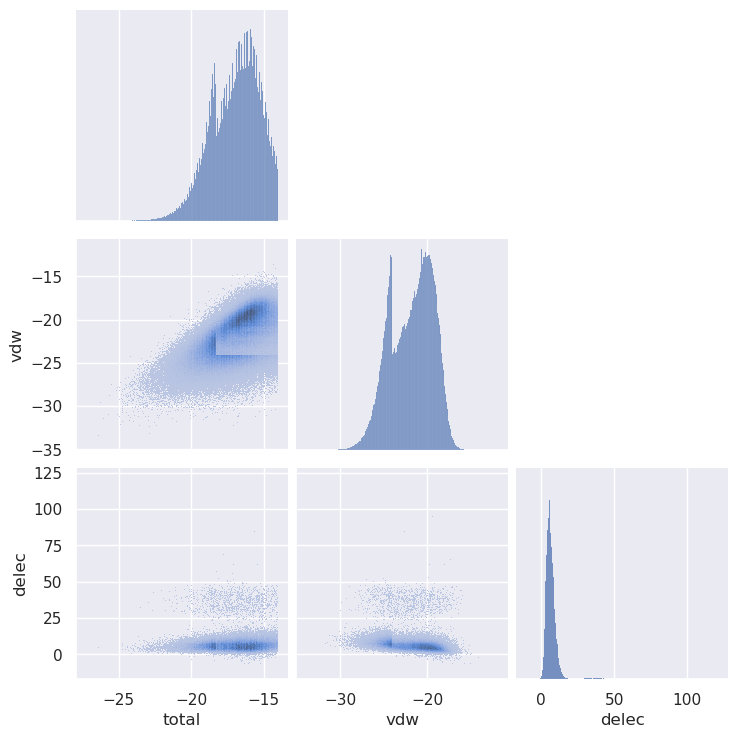

In [94]:
table2 = table[[ "total", "vdw", "delec"]]
sns.pairplot(table2,  corner=True, kind="hist")

/home/miemie/miniconda3/envs/mlprod/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

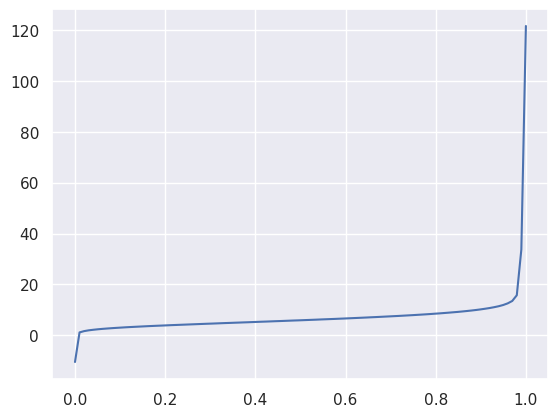

In [99]:
xs = []
ys = []
for i in np.linspace(0,1,100):
  val = np.quantile(table.delec, i)
  xs.append(i)
  ys.append(val)
sns.lineplot(xs,ys)